# Emotion Detection con tecniche di Deep Learning

## Import delle librerie

In [1]:
from tensorflow import keras
from keras.layers import Input, SimpleRNN, LSTM, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Activation, MaxPool1D, Bidirectional
from keras.models import load_model
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

import os
import glob
import math
import wave #used to calculate audio file length
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio #used for cleaning too long cells output, used to play tracks
import librosa
import librosa.display

from imblearn.over_sampling import SMOTENC

## Utility variables

In [2]:
augmented_dataset = True #work with augmented dataset or with the default one
use_smotenc = True #set to True to use SMOTENC augmentation during traing set data sampling
standardize_data = True

dataset_path = "Audio_Speech_Actors_01-24"
dataframe_path = "dataframe.csv"
dataframe_aug_path = "dataframe-aug.csv"

## Utility functions

In [3]:
def plot_history(loss_values, accuracy_values, f1_values, plot_file_name="plot"):
  fig, ax1 = plt.subplots(figsize=(10, 8))
  ax1.set_title("Accuracy, loss and f1 trend")
  
  #get number of cross-validation training iteration
  iteration_count = len(loss_values)
  #print x axis label
  ax1.set_xlabel('Epochs') 

  #print loss trend
  line1, = ax1.plot(range(1,iteration_count+1),loss_values,label='loss',color='orange')
  #show y axis label and color axis values
  ax1.tick_params(axis='y', labelcolor=line1.get_color())

  #clone y axis
  ax2 = ax1.twinx()
  #print accuracy trend
  line2, = ax2.plot(range(1,iteration_count+1),accuracy_values,label='accuracy')
  #color axis values
  ax2.tick_params(axis='y', labelcolor=line2.get_color())

  #clone y axis
  ax3 = ax2.twinx()
  #print accuracy trend
  line3, = ax3.plot(range(1,iteration_count+1),f1_values,label='f1', color='red')
  #color axis values
  ax3.tick_params(axis='y', labelcolor=line3.get_color())
  
  #show legend
  fig.legend(loc=(0.8,0.8))
  #save figure
  fig.savefig("{}.png".format(plot_file_name))

## Dataset

Il dataset è una sottoporzione del dataset RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song). Mentre il RAVDESS puro contiene 24.8GB di discorsi e di canzoni, audio e video, il RAVDESS Emotional speech audio contiene solo audio di discorsi.

Il dataset contiene 60 tracce audio per ognuno dei 24 attori, per un totale di 1440 file in formato war. Gli attori (12 maschi e 12 femmine) pronunciano 2 frasi (2 volte ciascuna) con un accento neutro del Norm America esprimendo emozioni differenti (calma, felicità, tristezza, rabbia, paura, sorpresa e disgusto) a 2 differenti livelli di intensità (medio, alto) più un'espressione neutra.

La **naming convention** dei file del dataset è la seguente: ognuno dei 1440 file è identificato da una successione di 7 identificatori numerici (es. 03-01-06-01-02-01-12.wav) e ognuno di questi numeri ha un significato specifico:

* **Modalità** (01: audio-video, 02: solo video, 03: solo audio)
  * in questa sottoporzione del dataset la modalità è sempre audio-only
* **Canale vocale** (01: parlato, 02: cantato)
  * in questa sottoporzione del dataset il canale vocale è sempre parlato 
* **Emozione** (01: neutra, 02: calma, 03: felicità, 04: tristezza, 05: rabbia, 06: paura, 07: disgusto, 08: sorpresa)
* **Intensità** (01: normale, 02: forte)
  * per l'emozione neutra non c'è intensità
* **Frase** (01: "Kids are talking by the door", 02: "Dogs are sitting by the door")
* **Ripetizione** (01: prima ripetizione, 02: seconda ripetizione)
* **Attore** (01...24, gli attori dispari sono maschi, mentre quelli pari sono femmine)

### Funzione di campionamento

Viene definita una utility function `sample_track` che restituisce in output il path di una traccia casuale campionato dal dataset.

In [4]:
def sample_track():
  #choose a random folder
  folders = sorted(glob.glob(dataset_path+"/*"), key=len)
  random_folder = np.random.choice(folders)
  #choose and return a random track
  tracks = sorted(glob.glob(random_folder+"/*.wav"), key=len)
  random_track = np.random.choice(tracks)
  return random_track  

In [5]:
#sampling function testing 
random_track = sample_track()
#track visualization
Audio(random_track)

### Caricamento dei file audio

La funzione [load](https://librosa.org/doc/main/generated/librosa.load.html) di librosa permette di caricare un file audio come una sequenza temporale di valori floating point.

* `path` indica alla funzione il path del file caricare

La funzione restituisce la sequenza di valori floating point e la frequenza di campionatura (espressa in Hz). Il valore di default per la frequenza di campionatura è di 22.050 Hz, il che significa che una traccia audio di 3 secondi viene caricata come un vettore di 66.150 valori floatin point.

In [6]:
#load the audio track as a floating point time series
time_series, sampling_rate = librosa.load(path=random_track)
print("sampling_rate: {}".format(sampling_rate))
print("time_series length: {}".format(len(time_series)))

sampling_rate: 22050
time_series length: 89025


la funzione `get_audio_length` restituisce la durata in secondi della traccia audio passata in input. Usa il package [wave](https://docs.python.org/3/library/wave.html) per estrarre l'informazione dai file WAV.

* `path` è il percorso della traccia audio

La funzione viene usata per verificare la lunghezza della serie temporale estratta da librosa, basterà infatti moltiplicare la lunghezza del file per il rateo di campionatura e controllare se il valore coincide con il numero di valori estratti da librosa. 


In [7]:
def get_audio_length(path):
    file = wave.open(path, 'r')
    frames = file.getnframes()
    #print("frames: ", frames)
    rate = file.getframerate()
    #print("frame rate: ", rate)
    return frames / float(rate)

In [8]:
audio_length = get_audio_length(random_track)
print("audio length: {}".format(audio_length))
print("expected time series length: {}".format(math.ceil(audio_length * sampling_rate)))

audio length: 4.037375
expected time series length: 89025


### Forma d'onda

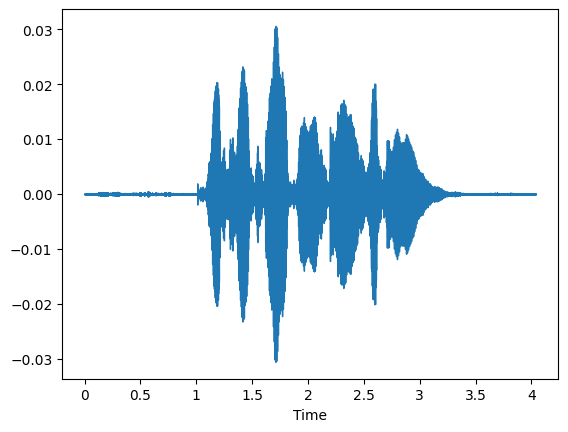

In [9]:
librosa.display.waveshow(y=time_series, sr=sampling_rate)

### Spettro d'onda

'\nps = librosa.feature.melspectrogram(y=time_series, sr=sampling_rate)\nlibrosa.display.waveshow(ps, sr=sampling_rate)\n'

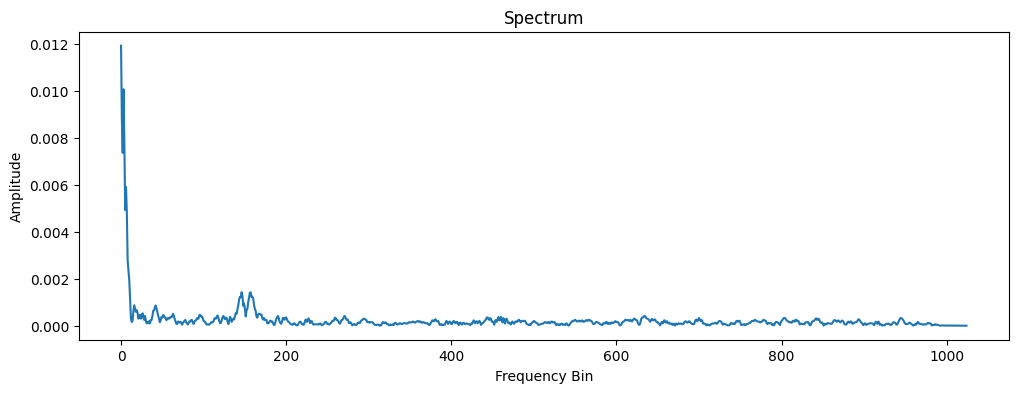

In [10]:
n_fft = 2048
plt.figure(figsize=(12, 4))
ft = np.abs(librosa.stft(time_series[:n_fft], hop_length = n_fft+1))
plt.plot(ft);
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

"""
ps = librosa.feature.melspectrogram(y=time_series, sr=sampling_rate)
librosa.display.waveshow(ps, sr=sampling_rate)
"""

### Spettrogramma

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

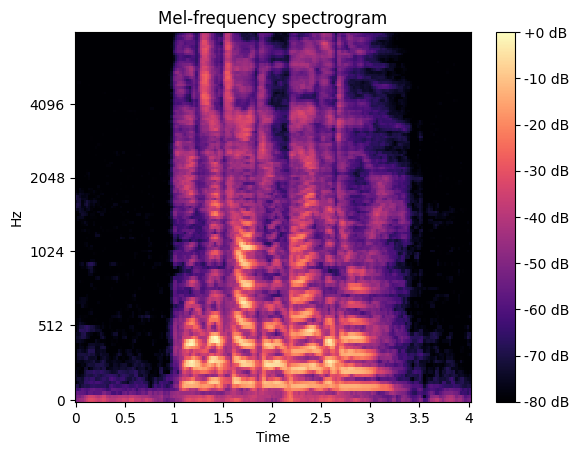

In [11]:
S = librosa.feature.melspectrogram(y=time_series, sr=sampling_rate, n_mels=128,
                                    fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sampling_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')


### Visualizzazione

Per fini di visualizzazione viene costruito un DataFrame Pandas ottenuto dalle informazioni codificate nei nomi dei singoli file. In particolare le colonne saranno le seguenti: `Path`, `Emotion`, `Intensity`, `Statement`, `Actor`, `Gender`.

Prima vengono generati array di valori in base ai codici contenuti nei nomi dei file, poi quegli array vengono convertiti in dataframe con una singola colonna e infine i dataframes vengono concatenati per comporre il dataframe obiettivo.

In [12]:
directories = os.listdir(dataset_path)

#support arrays to store database values
emotion_col = []; intensity_col = []; statement_col = []; actor_col = []; gender_col = []; path_col = []

#iterate over dataset folders (every folder is relative to a different actor)
for dir_name in directories:
  dir_files = os.listdir(dataset_path + "/" + dir_name)
  #iterate over files in the current directory
  for file_name in dir_files:
    #file name splitting: first remove WAV extension then split over '-' chars
    file_parts = file_name.split('.')[0].split('-')
    #store each value into the relative array
    emotion_col.append(int(file_parts[2]))
    intensity_col.append(int(file_parts[3]))
    statement_col.append(int(file_parts[4]))
    actor_col.append(int(file_parts[6]))
    gender_col.append(int(file_parts[6])%2) # %2 to keep only odd/even information
    path_col.append(dataset_path + "/" + dir_name + "/" + file_name)

#convert arrays to dataframes and chain them in a single dataframe
emotion_df = pd.DataFrame(emotion_col, columns=['Emotion'])
intensity_df = pd.DataFrame(intensity_col, columns=['Intensity'])
statement_df = pd.DataFrame(statement_col, columns=['Statement'])
actor_df = pd.DataFrame(actor_col, columns=['Actor'])
gender_df = pd.DataFrame(gender_col, columns=['Gender'])
path_df = pd.DataFrame(path_col, columns=['Path'])

#convert integer in dataframe with their value following the naming convention
#  inplace param added to edit the current dataframe instead of creating a new one
emotion_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'}, inplace=True)
intensity_df.replace({1:'normal', 2:'strong'}, inplace=True)
statement_df.replace({1:'Kids are talking by the door', 2:'Dogs are sitting by the door'}, inplace=True)
gender_df.replace({1:'male', 0:'female'}, inplace=True)

files_df = pd.concat([path_df, emotion_df, intensity_df, statement_df, actor_df, gender_df], axis=1) #axis=1 to concatenate columns instead of rows
files_df

,Path,Emotion,Intensity,Statement,Actor,Gender
0,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,neutral,normal,Kids are talking by the door,1,male
1,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,neutral,normal,Kids are talking by the door,1,male
2,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,neutral,normal,Dogs are sitting by the door,1,male
3,Audio_Speech_Actors_01-24/Actor_01/03-01-01-01...,neutral,normal,Dogs are sitting by the door,1,male
4,Audio_Speech_Actors_01-24/Actor_01/03-01-02-01...,calm,normal,Kids are talking by the door,1,male
...,...,...,...,...,...,...
1435,Audio_Speech_Actors_01-24/Actor_24/03-01-08-01...,surprised,normal,Dogs are sitting by the door,24,female
1436,Audio_Speech_Actors_01-24/Actor_24/03-01-08-02...,surprised,strong,Kids are talking by the door,24,female
1437,Audio_Speech_Actors_01-24/Actor_24/03-01-08-02...,surprised,strong,Kids are talking by the door,24,female
1438,Audio_Speech_Actors_01-24/Actor_24/03-01-08-02...,surprised,strong,Dogs are sitting by the door,24,female


Vengono contati i valori assumibili dalla colonna Emotions del dataframe per definire il numero di classi possibili

In [13]:
classes_count = files_df["Emotion"].nunique()
print("Number of possible classes (emotions): {}".format(classes_count))

Number of possible classes (emotions): 8


In [14]:
#numero di entry per ogni classe
files_df["Emotion"].value_counts()

calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: Emotion, dtype: int64

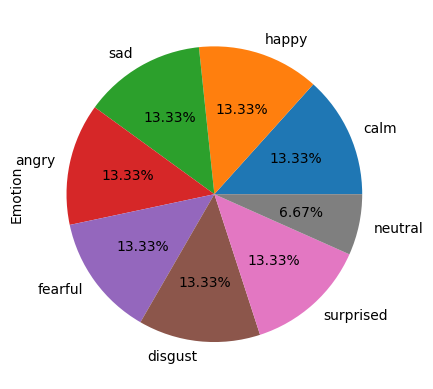

In [15]:
#percentuale di entry appartenenti alle vare classi rispetto alla totalità del dataset 
files_df["Emotion"].value_counts().plot.pie(autopct="%.2f%%");

### Augmentation

Sono state usate tecniche di data augmentation per incrementare la dimensione del dataset. Per la fonte dei metodi si rimanda al notebook [Audio Emotion | Data Augmentation](https://www.kaggle.com/code/ejlok1/audio-emotion-part-5-data-augmentation).

Le tecniche usate sono le seguenti:

* static noise
* shift
* stretch
* pitch
* dynamic change
* speed and pitch

Nei sottoparagrafi successivi vengono implementati i metodi e testati su un file audio di test.

In [16]:
time_series, sampling_rate = librosa.load(path=random_track)
Audio(time_series, rate=sampling_rate)

#### Static noise

Il metodo `add_static_noise` aggiunge del rumore di fondo al file passato in input. 

In [17]:
def add_static_noise(time_series):
    noise_amp = 0.05 * np.random.uniform() * np.amax(time_series)
    return time_series.astype('float64') + noise_amp * np.random.normal(size=time_series.shape[0])

noised_time_series = add_static_noise(time_series)
Audio(noised_time_series, rate=sampling_rate)

#### Shift

In [18]:
def shift_audio(time_series):
    #numpy.random.uniform
    shift_range = int(np.random.uniform(low=5,high=5) * 1000)
    return np.roll(time_series,shift_range)

shifted_time_series = shift_audio(time_series)
print(len(shifted_time_series))
Audio(shifted_time_series, rate=sampling_rate)

89025


#### Stretch

In [19]:
def stretch_audio(time_series):
    return librosa.effects.time_stretch(time_series,rate=0.9)

stretched_time_series = stretch_audio(time_series)
Audio(stretched_time_series, rate=sampling_rate)

#### Pitch

https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html

In [20]:
def pitch_audio(time_series, sampling_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    return librosa.effects.pitch_shift(y=time_series.astype('float64'),
                                       sr=sampling_rate,
                                       n_steps=pitch_change,
                                       bins_per_octave=bins_per_octave)

pitched_time_series = pitch_audio(time_series, sampling_rate)
Audio(pitched_time_series, rate=sampling_rate)

#### Dynamic change

In [21]:
def dynamic_change(time_series):
    return time_series * np.random.uniform(low=-0.5,high=7)

changed_time_series = dynamic_change(time_series)
Audio(changed_time_series, rate=sampling_rate)

#### Speed and pitch

In [22]:
def speed_and_pitch(time_series):
    length_change = np.random.uniform(low=0.8,high=1)
    speed_factor = 1.2 / length_change
    tmp = np.interp(np.arange(0,len(time_series),speed_factor), np.arange(0,len(time_series)), time_series)
    minlen = min(time_series.shape[0], tmp.shape[0])
    time_series *= 0
    time_series[0:minlen] = tmp[0:minlen]
    return time_series

sap_time_series = speed_and_pitch(time_series)
Audio(sap_time_series, rate=sampling_rate)

### Features

Dal dataset vengono estratte le features usando le funzioni offerte dalla libreria librosa:

* [chroma](https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html): **TODO** (12 valori per ogni file)
* [mel spctrogram](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html): spettrogramma dove le frequenze sono state convertine nella scala MEL (128 valori per ogni file)
* [mfcc](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html): **TODO** (40 valori per ogni file)
* [spectral contrast](https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html): **TODO** (7 valori per ogni file)
* [tonnetz](https://librosa.org/doc/main/generated/librosa.feature.tonnetz.html): **TODO** (6 valori per ogni file)

I valori indicati tra parentesi (12,128,40,7,6 = **193 features**) indicano il numero di colonne di ogni feature, che verranno aggiunte al dataframe Pandas, corredato con l'informazione di classe (corrispondente all'emozione espressa nella traccia audio) del file corrispondente.

<!--
La **Fourier Transform** (FT) è una funzione matematica in grado di decomporre un segnale nelle sue frequenze costituenti corredate dalle relative magnitudo. La FT permette di passare dal dominio del tempo (time-domain) a quello della frequenza (frequency-domain).

<div>
<img src="https://drive.google.com/uc?id=12vRYA33koEKGD2fvZOYKUxMBhkXzd3ab"/>
</div>

La libreria librosa contiene una funzione per il calcolo della **Discrete Fourier Transform** (DFT), chiamata anche **Fast Fourier Transform** (FFT), funzione matematica che si differenzia dalla FT per il fatto di prendere un input discreto, piuttosto che un input continuo come nella FT standard.

La frequenza cambia nel tempo, quindi una FT su tutta la traccia audio può non essere rappresentativa. La **Short-Time Fourier Transform** (STFT) effettua una FT su sottoporzioni della traccia stessa.

La STFT viene calcolata usando la funzione [stft](https://librosa.org/doc/main/generated/librosa.stft.html) di librosa, che di norma restituisce un vettore di numeri complessi (float64), che codificano fase e ampiezza del segnale audio, ma la fase, oltre a non venire percepita dall'essere umano, non è utile ai fini dell'esperimento, quindi convertono i valori della sequenza temporale in valori assoluti (float32).

**TODO** parlare del binning
-->

#### Estrazione

La funzione `get_features` estrae le 193 features dal file passato in input e restituisce 5 array, uno per ogni categoria di feature sopraelencata.

* `file_path` è il percorso del file per il quale estrarre le features

In [23]:
def get_features(time_series, sampling_rate=22050):
  stft = np.abs(librosa.stft(time_series))

  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T,axis=0)
  mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=time_series, sr=sampling_rate).T,axis=0)
  mfcc = np.mean(librosa.feature.mfcc(y=time_series, sr=sampling_rate, n_mfcc=40).T,axis=0)
  spectral_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sampling_rate).T,axis=0)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(time_series), sr=sampling_rate).T,axis=0)
  return chroma, mel_spectrogram, mfcc, spectral_contrast, tonnetz

La funzione `get_feature_dataframe` restituisce un dataframe Pandas contenente le feature estratte da ogni file del dataset. Il dataframe conterrà quindi una riga per ogni file nel dataset (**1440 righe** nella forma standard, **10.080 righe** nella versione estesa applicando la data augmentation) e una colonna per ogni feature più una colonna per ogni classe possibile (**193 + 8 = 201 colonne**).

Per la classe di appartenenza è stata utilizzata una rappresentazione in One Hot Encode (usando la funzione [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) di Pandas) per evitare che il modello apprenda relazioni in realtà non esistenti tra i valori della classe dei dati.

In [24]:
def get_time_series_list(augment):
  #define time series lists (for standard ts and for augmented ts)
  ts_list = []; ts_static_noise = []; ts_shift = []; ts_stretch = []; ts_pitch = []; ts_dyn_change = []; ts_sep = []
  #time series extraction from files
  for _,row in files_df.iterrows():
    time_series,_ = librosa.load(path=row['Path'])
    ts_list.append(time_series)    
    #populate augmented time series lists  
    if augment:
      ts_static_noise.append(add_static_noise(time_series))
      ts_shift.append(add_static_noise(time_series))
      ts_stretch.append(add_static_noise(time_series))
      ts_pitch.append(add_static_noise(time_series))
      ts_dyn_change.append(add_static_noise(time_series))
      ts_sep.append(add_static_noise(time_series))
  #merge time series lists
  if augment:
    ts_list = np.concatenate([ts_list, ts_static_noise, ts_shift, ts_stretch, ts_pitch, ts_dyn_change, ts_sep])
  return ts_list

In [25]:
def get_feature_dataframe(augment=False, standardize=True):
  #support arrays to store feature values
  chroma_col = []; mel_spectrogram_col = []; mfcc_col = []; spectral_contrast_col = []; tonnetz_col = []

  #features extraction from time series
  for time_series in get_time_series_list(augment):
    chroma, mel_spectrogram, mfcc, spectral_contrast, tonnetz = get_features(time_series)

    chroma_col.append(chroma)
    mel_spectrogram_col.append(mel_spectrogram)  
    mfcc_col.append(mfcc)
    spectral_contrast_col.append(spectral_contrast)
    tonnetz_col.append(tonnetz)

  #convert feature arrays to pandas dataframes and chain them them to obtain the feature dataframe
  chroma_df = pd.DataFrame(chroma_col)
  chroma_df.rename(columns=lambda i: 'Chroma_' + str(i+1), inplace=True)

  mel_df = pd.DataFrame(mel_spectrogram_col)
  mel_df.rename(columns=lambda i: 'MelSpectrogram_' + str(i+1), inplace=True)

  mfcc_df = pd.DataFrame(mfcc_col)
  mfcc_df.rename(columns=lambda i: 'MFCC_' + str(i+1), inplace=True)

  contrast_df = pd.DataFrame(spectral_contrast_col)
  contrast_df.rename(columns=lambda i: 'SpectralContrast_' + str(i+1), inplace=True)

  tonnetz_df = pd.DataFrame(tonnetz_col)
  tonnetz_df.rename(columns=lambda i: 'Tonnetz_' + str(i+1), inplace=True)

  features_df = pd.concat([chroma_df, mel_df, mfcc_df, contrast_df, tonnetz_df], axis=1)

  emotion_df_ohe = pd.get_dummies(data=emotion_df, prefix="emotion", columns=["Emotion"])

  if(augment):
    actor_df2 = pd.concat([actor_df]*7, ignore_index=True)
    emotion_df_ohe2 = pd.concat([emotion_df_ohe]*7, ignore_index=True)
    result_dataframe = pd.concat([actor_df2, features_df, emotion_df_ohe2], axis=1)

    if use_smotenc:
      print("before SMOTENC: ", result_dataframe.shape)
      non_class_cols = [col for col in result_dataframe.columns if 'emotion' not in col]
      classes = result_dataframe[[col for col in result_dataframe.columns if 'emotion' in col]]
      classes = classes[classes==1].stack().reset_index().drop(0, axis=1)['level_1']
      sm = SMOTENC(random_state=42, categorical_features=np.arange(1,194))
      train_data,train_classes = sm.fit_resample(result_dataframe[non_class_cols], classes)
      #recreate pandas dataframe
      train_data = pd.DataFrame(train_data, columns=train_data.columns)
      train_classes_ohe = pd.get_dummies(data=train_classes, columns=["Emotion"])
      train_data[train_classes_ohe.columns] = train_classes_ohe

      result_dataframe = train_data
      print("after SMOTENC: ", result_dataframe.shape) #aggiunte 672 righe -> 28 entry per ogni attore
    
    return result_dataframe
  else:
    return pd.concat([actor_df, features_df, emotion_df_ohe], axis=1)

Per valutare l'efficacia dell'augmentation del dataset sono stati condotti due training usando lo stesso modello (LSTM), il primo utilizzando il dataset standard e il secondo usando la versione estesa.

### Creazione del dataframe

Il seguente blocco di codice permette di decidere se ricreare il dataframe o se caricare la versione salvata su Drive, risparmiando il tempo necessario per la costruzione.

In [26]:
def get_dataframe(augmented=False):
  path = dataframe_aug_path if augmented else dataframe_path
  if os.path.exists(path):
    #create dataframe from CSV file
    dataframe = pd.read_csv(path)
  else:
    #create dataframe from dataset
    print("creating dataframe...")
    dataframe = get_feature_dataframe(augmented)
    print("dataframe creation completed!")
    #save dataframe ad CSV file
    dataframe.to_csv(path, index=False) #index param avoid to save row names (unused information)
  return dataframe

In [27]:
dataframe = get_dataframe(False)
dataframe_aug = get_dataframe(True)
print("standard dataframe shape: {}, augmented dataframe shape: {}".format(dataframe.shape, dataframe_aug.shape))

standard dataframe shape: (1440, 202), augmented dataframe shape: (10752, 202)


In [28]:
#utility variables like number of features and array-like feature and class columns
features_count = len([col for col in dataframe.columns if 'emotion' not in col and 'Actor' not in col])
print("features for every file: {}".format(features_count))

#identify class and feature columns
feature_cols = [col for col in dataframe.columns if 'emotion' not in col and 'Actor' not in col]
class_cols = [col for col in dataframe.columns if 'emotion' in col]

features for every file: 193


Viene usata la funzione [info](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) dei DataFrame Pandas per visualizzare informazioni interessanti sul DataFrame. A causa del elevato numero di colonne è necessario impostare il parametro `verbose` per forzare la visualizzazione completa.

In [29]:
dataframe.info()
#dataframe.info(verbose=True) #used only for debug purpose

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Columns: 202 entries, Actor to emotion_surprised
dtypes: float64(193), int64(9)
memory usage: 2.2 MB


In [30]:
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Actor,1440.0,12.500000,6.924591,1.000000,6.750000,12.500000,18.250000,24.000000
Chroma_1,1440.0,0.650806,0.075172,0.367214,0.602087,0.658002,0.705129,0.836432
Chroma_2,1440.0,0.652753,0.084716,0.322201,0.595711,0.659514,0.719106,0.859350
Chroma_3,1440.0,0.657626,0.087688,0.317739,0.596618,0.664997,0.725918,0.858602
Chroma_4,1440.0,0.669408,0.090251,0.356032,0.604171,0.683644,0.736847,0.865664
...,...,...,...,...,...,...,...,...
emotion_fearful,1440.0,0.133333,0.340053,0.000000,0.000000,0.000000,0.000000,1.000000
emotion_happy,1440.0,0.133333,0.340053,0.000000,0.000000,0.000000,0.000000,1.000000
emotion_neutral,1440.0,0.066667,0.249530,0.000000,0.000000,0.000000,0.000000,1.000000
emotion_sad,1440.0,0.133333,0.340053,0.000000,0.000000,0.000000,0.000000,1.000000


In [31]:
#standardize features
if (standardize_data):
    scaler = StandardScaler()
    data = dataframe[feature_cols] #need to standardize only features
    scaler.fit(data)
    dataframe[feature_cols] = scaler.transform(data) #replace columns with standardized data
    
    dataframe.describe().transpose()

### Splitting

In [32]:
available_actor_indexes = dataframe['Actor'].unique()
test_actor_indexes = [1, 12, 7, 24]
validation_actor_indexes = [2,13,8,23]
#subtraction with list comprehension
training_actor_indexes = [x for x in available_actor_indexes if x not in test_actor_indexes and x not in validation_actor_indexes]
print("training actors are {} over a total of {}"
      .format(len(training_actor_indexes),len(available_actor_indexes)))

#test and validation set are sampled from not-augmented dataset
test_set = dataframe.loc[dataframe['Actor'].isin(test_actor_indexes)]
validation_set = dataframe.loc[dataframe['Actor'].isin(validation_actor_indexes)]
#project validation set to get separately data and classes
validation_data = validation_set[feature_cols]
validation_classes = validation_set[class_cols]
#reshape data
validation_data = validation_data.to_numpy()
validation_data = validation_data.reshape((validation_data.shape[0], validation_data.shape[1], 1))

#display dataset subset shape
print("Shapes -> validation set: {}, test set: {}"
      .format(validation_set.shape, test_set.shape))

training actors are 16 over a total of 24
Shapes -> validation set: (240, 202), test set: (240, 202)


## Funzione di training

In [33]:
#emotion: used to train mono class classifier
def cross_validation(model, iterations, emotion="all"):
  #define array of metrics, one value for every cross-validation iteration
  model_loss = []; model_accuracy = []; model_f1 = []

  #on every iteration fix a different actor, train on the other actors and test on him
  for iteration in range(iterations):
    fold_index = 0 #used to print the index of the current processing fold

    for test_actor_index in training_actor_indexes:
      
      cross_train_actor_indexes = [x for x in training_actor_indexes if x != test_actor_index]
      #define train and test set for the current iteration (training set created from augmented dataframe)
      cross_test_set = dataframe.loc[dataframe['Actor'].isin([test_actor_index])]
      if (augmented_dataset):
        cross_training_set = dataframe_aug.loc[dataframe_aug['Actor'].isin(cross_train_actor_indexes)]
      else:
        cross_training_set = dataframe.loc[dataframe['Actor'].isin(cross_train_actor_indexes)]
      #select only 1 col if train a single class model
      classes = class_cols if emotion == "all" else "emotion_{}".format(emotion)
      #project training set and test set to get separately data and classes
      train_data = cross_training_set[feature_cols]
      train_classes = cross_training_set[classes]
      test_data = cross_test_set[feature_cols]
      test_classes = cross_test_set[classes]
      #reshape data
      train_data = train_data.to_numpy().reshape((train_data.shape[0], train_data.shape[1], 1))
      test_data = test_data.to_numpy().reshape((test_data.shape[0], test_data.shape[1], 1))
      # fit the classifier
      fold_index += 1
      history = model.fit(x=train_data, y=train_classes, verbose=0)
      # compute the score and record it
      test_result = model.evaluate(x=test_data, y=test_classes, verbose=0)
      predicted_classes = model.predict(test_data)
      #revert ohe and convert classes for f1 calculation
      test_classes_arr = test_classes
      if (emotion == "all"):
        test_classes_arr = test_classes[test_classes==1].stack().reset_index().drop(0, axis=1)['level_1']
        test_classes_arr.replace({'emotion_neutral':1, 'emotion_calm':2, 'emotion_happy':3, 'emotion_sad':4, 'emotion_angry':5, 'emotion_fearful':6, 'emotion_disgust':7, 'emotion_surprised':8}, inplace=True)
      predicted_classes=np.argmax(predicted_classes, axis=1) 
      # store metrics values
      model_loss.append(test_result[0])
      model_accuracy.append(test_result[1])
      model_f1.append(f1_score(test_classes_arr, predicted_classes, average="macro"))

      print("Iter {}/{}, Fold {}/{}, {} data, fit:[loss:{:.4f}, acc:{:.4f}] test:[loss:{:.4f}, acc:{:.4f}, f1:{:.4f}]".format(
          iteration+1, iterations, fold_index, len(training_actor_indexes), train_data.shape[0],
          history.history['loss'][0], history.history['accuracy'][0], model_loss[-1], model_accuracy[-1], model_f1[-1]))
    
  return model_loss, model_accuracy, model_f1


## RNN base

Il primo esperiemnto viene condotto usando una RNN many-to-one standard, cioè con un unico nodo. 

### Definizione del modello

[SimpleRNN](https://keras.io/api/layers/recurrent_layers/simple_rnn/)

In [34]:
#use softmax for multi-class classification
def build_simple_rnn(n_feature,n_classes):
  model = keras.Sequential(
      [
        Input(shape=(n_feature,1)),
        #SimpleRNN(n_classes, activation="softmax")
        
        SimpleRNN(8, activation="relu"),
        #Dense(n_classes, activation="sigmoid")
        Dense(1, activation="sigmoid")
      ]
    )
  
  loss = BinaryCrossentropy()
  optimizer = Adam()
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

### Creazione del modello

In [35]:
simple_rnn = build_simple_rnn(features_count, classes_count)

### Visualizzazione del modello

In [36]:
simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


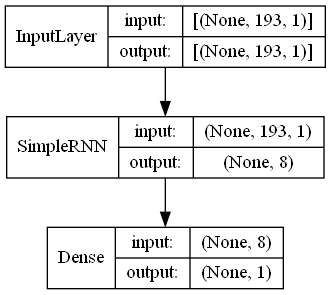

In [37]:
plot_model(simple_rnn, show_shapes=True, show_layer_names=False)

### Training del modello

In [38]:
#loss, accuracy, f1 = cross_validation(simple_rnn,1,"angry")

In [39]:
#plot_history(loss, accuracy, f1, "simple-rnn")

## RNN bidirezionale

### Definizione del modello

[Bidirectional layer](https://keras.io/api/layers/recurrent_layers/bidirectional/)

In [40]:
def build_brnn(n_feature,n_classes):
  model = keras.Sequential(
      [
        Input(shape=(n_feature,1)),
        Bidirectional(SimpleRNN(8, activation="relu"), merge_mode='ave'),
        Dense(n_classes, activation="softmax")
      ]
    )
  
  loss = BinaryCrossentropy()
  optimizer = Adam()
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

### Creazione del modello

In [41]:
brnn = build_brnn(features_count, classes_count)

### Visualizzazione del modello

In [42]:
brnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 8)                160       
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________


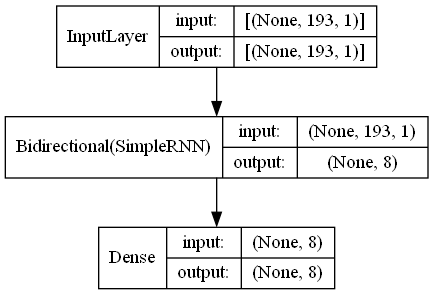

In [43]:
plot_model(brnn, show_shapes=True, show_layer_names=False)

### Training del modello

In [44]:
#loss, accuracy, f1 = cross_validation(brnn,30)

In [45]:
#plot_history(loss, accuracy, f1, "simple-rnn")

## LSTM

### Definizione del modello

In [57]:
def build_lstm(n_feature,n_classes):
  model = keras.Sequential(
      [
        Input(shape=(n_feature,1)),
        LSTM(8, activation="relu", return_sequences=True, dropout=0.2),
        Dense(n_classes, activation="sigmoid")
      ]
    )
  
  loss = BinaryCrossentropy()
  optimizer = Adam()
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

### Creazione del modello

In [51]:
lstm = build_lstm(features_count, 1)

### Visualizzazione del modello

In [52]:
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 193, 8)            320       
                                                                 
 dense_3 (Dense)             (None, 193, 1)            9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


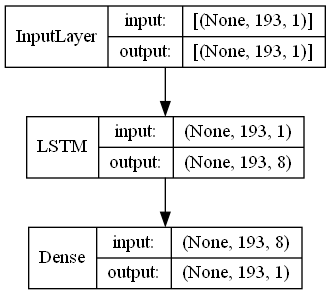

In [53]:
plot_model(lstm, show_shapes=True, show_layer_names=False)

### Training del modello

In [54]:
#loss, accuracy, f1 = cross_validation(lstm, 30)


In [55]:
#plot_history(loss, accuracy, f1, "simple-lstm")

In [58]:
#populate model folder for multi-classifier
for c in class_cols:
#for c in ["emotion_disgust"]:
    emo = c.replace("emotion_","") #get emotion
    print("doing {} model".format(emo))
    lstm = build_lstm(features_count, 1) #get compiled model
    loss, accuracy, f1 = cross_validation(lstm, 1, emo) #train model
    lstm.save("models/{}_model.h5".format(emo)) #save model
    del lstm #free space deleting model

doing angry model
2/2 [==============================] - 0s 37ms/step
Iter 1/1, Fold 1/16, 6714 data, fit:[loss:0.4823, acc:0.8617] test:[loss:0.3469, acc:0.8737, f1:0.0659]
2/2 [==============================] - 0s 57ms/step
Iter 1/1, Fold 2/16, 6706 data, fit:[loss:0.3495, acc:0.8820] test:[loss:0.3648, acc:0.8667, f1:0.0768]
2/2 [==============================] - 0s 76ms/step
Iter 1/1, Fold 3/16, 6706 data, fit:[loss:0.3417, acc:0.8852] test:[loss:0.3755, acc:0.8706, f1:0.0585]
2/2 [==============================] - 0s 38ms/step
Iter 1/1, Fold 4/16, 6726 data, fit:[loss:0.3360, acc:0.8881] test:[loss:0.3817, acc:0.8667, f1:0.1328]
2/2 [==============================] - 0s 42ms/step
Iter 1/1, Fold 5/16, 6715 data, fit:[loss:0.3346, acc:0.8911] test:[loss:0.3123, acc:0.9136, f1:0.0969]
2/2 [==============================] - 0s 36ms/step
Iter 1/1, Fold 6/16, 6715 data, fit:[loss:0.3273, acc:0.8931] test:[loss:0.3371, acc:0.8999, f1:0.0157]
2/2 [==============================] - 0s 55ms

## Advanced Net

### Definizione del modello

In [ ]:
def build_model(n_feature,n_classes):
  model = keras.Sequential(
      [
        Input(shape=(n_feature,1)),
        Conv1D(256, 5, padding="same", activation='relu'),
        Dropout(0.1),
        MaxPool1D(pool_size=(8)),
        Conv1D(128, 5, padding="same", activation='relu'),
        Conv1D(128, 5, padding="same", activation='relu'),
        Flatten(),
        Dense(n_classes, activation="softmax")
      ]
    )
  
  loss = BinaryCrossentropy()
  optimizer = Adam(learning_rate=0.0001)
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
  return model

### Creazione del modello

In [ ]:
model = build_model(features_count, classes_count)

### Visualizzazione del modello

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

### Training del modello

In [ ]:
#loss, accuracy, f1 = cross_validation(model,20)

In [ ]:
#plot_history(loss, accuracy, f1, "custom-model")

## Multi-classificatore

In [71]:
class MultiClassifier:

    def __init__(self):
        self.models = {}
        for c in class_cols:
            lstm = load_model("models/{}_model.h5".format(c.replace("emotion_","")))
            self.models[c] = lstm
    
    #input: data to classify
    #return a dataframe with a row for every data: every row contains the probability of a class
    def predict(self, data):
        #data reshape
        data = data.to_numpy().reshape((data.shape[0], data.shape[1], 1))
        #create an empty dataframe with 1 row for every data and a column for every emotion to predict with a different model
        pred_df = pd.DataFrame(index=range(data.shape[0]), columns=class_cols)
        for c in class_cols:
            prediction = self.models[c].predict(data)
            pred_df[c] = prediction.mean(axis=1)
        
        return pred_df
    
    def test(self, data):
        pred = self.predict(data[feature_cols])
        #select class with highest value for every row and convert it in an array
        y_pred = pred.idxmax(axis=1).values
        #get classes array from data
        data_classes = data[class_cols]
        y_true = data_classes[data_classes==1].stack().reset_index().drop(0, axis=1)['level_1']
        y_true = y_true.values
        #calculate accuracy
        return accuracy_score(y_true, y_pred)

mc = MultiClassifier()

8/8 [==============================] - 0s 21ms/step


0.25833333333333336

In [68]:
mc.test(test_set)

(240, 202)
(240, 193)
data:  (240, 193, 1)
pred df:  (240, 8)
8/8 [==============================] - 0s 22ms/step
pred:  (240, 193, 1)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Risultati del training

In [ ]:
#print("evaluation with simple rnn")
#simple_rnn.evaluate(validation_data, validation_classes)

print("evaluation with bidi rnn")
brnn.evaluate(validation_data, validation_classes)

#print("evaluation with simple lstm")
#lstm.evaluate(validation_data, validation_classes)

#print("evaluation with custom model")
#model.evaluate(validation_data, validation_classes)